# Demonstration: Detection de Fraude Neuromórfica

**Descrição:** Tutorial Interativo sobre o mecanismo biológico de aprendizado STDP (Plasticidade Dependente do Tempo de Spike) usado em redes neurais neuromórficas. Demonstra como os neurônios aprendem correlações temporais automaticamente.

**Autor:** Mauro Risonho de Paula Assumpção.
**Data de Criação:** 5 Dezembro 2025.
**Licença:** MIT License.
**Desenvolvimento:** Desenvolvimento Humano + Assistido por IA (Claude Sonnet 4.5, Gemini 3 Pro Preview).

---

Este notebook Demonstrars o complete pipeline de detecção de fraude usando Spiking Neural Networks (SNNs).

In [1]:
import sys
import os
from pathlib import Path

# Add src ao path
# Notebook é em: /portfolio/01_fraud_neuromorphic/notebooks/
# src é em: /portfolio/01_fraud_neuromorphic/src/
notebook_dir = Path.cwd()

# Verificar se estamos no diretório raiz do projeto ou no diretório notebooks
if (notebook_dir / 'portfolio' / '01_fraud_neuromorphic' / 'src').exists():
    # Estamos na raiz do projeto (Projeto-Neuromorfico-X)
    src_path = notebook_dir / 'portfolio' / '01_fraud_neuromorphic' / 'src'
elif (notebook_dir.parent / 'src').exists():
    # Estamos em notebooks/
    src_path = notebook_dir.parent / 'src'
elif (notebook_dir / 'src').exists():
    # Estamos em 01_fraud_neuromorphic/
    src_path = notebook_dir / 'src'
else:
    src_path = None

if src_path and src_path.exists():
    if str(src_path) não in sys.path:
        sys.path.insert(0, str(src_path))
        print(f" Diretório src adicionado: {src_path}")
else:
    print(f" Diretório src não found!")
    print(f"  Notebook dir: {notebook_dir}")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
from tqdm.auto import tqdm
import brian2

# Configurar Brian2 para usar numpy (evita errors de compilação C++ e problemas com SymPy/Cython)
brian2.prefs.codegen.target = "numpy"

# Nossos módulos
try:
    from main import FraudDetectionPipeline, generate_synthetic_transactions
    from encoders import RateEncoder, TemporalEncoder, PopulationEncoder, TransactionEncoder
    from models_snn import FraudSNN, demonstrate_lif_neuron  # type: ignore[attr-defined]
    print(" Imports dos project modules completed!")
except ImportError as e:
    print(f" error ao importar módulos: {e}")
    print(f"  sys.path: {sys.path[:3]}")

# Configuração de visualization
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

 Diretório src adicionado: /home/test/Downloads/github/portifolio/fraud-detection-neuromorphic/src


 Imports dos project modules completed!


## 2. Generation de dados Synthetics

Vamos criar a conjunto de dados synthetic de banking transactions com realistic patterns.

In [2]:
# Gerar 1000 transactions (5% fraudes)
print("Gerando transactions sintéticas...")
df = generate_synthetic_transactions(n=1000, fraud_ratio=0.05)

print(f"\n Dataset generated:")
print(f"total de transactions: {len(df)}")
print(f"Transactions legítimas: {np.sum(df['is_fraud'] == 0)}")
print(f"Transactions fraudulentas: {np.sum(df['is_fraud'] == 1)}")
print(f"rate de fraude: {df['is_fraud'].mean():.2%}")

# Mostrar primeiras linhas
df.head(10)

Gerando transactions sintéticas...

 Dataset generated:
Total de transactions: 1000
Transactions legítimas: 950
Transactions fraudulentas: 50
Rate de fraude: 5.00%


,id,amount,timestamp,merchant_category,location,device_id,daily_frequency,is_fraud
0,txn_000040,1.526213,1.763518e+09,entertainment,"(28.192729602458343, -54.82081056593087)",device_020,4,0
1,txn_000027,12.778882,1.763174e+09,groceries,"(27.291916839791647, 28.547630003492216)",device_062,4,0
2,txn_000744,11.687186,1.764943e+09,gas,"(26.83023701060364, -43.68807031592152)",device_003,2,0
3,txn_000077,28.320497,1.763274e+09,restaurants,"(-24.869488148731914, -35.05364938247672)",device_018,8,0
4,txn_000571,84.777523,1.763515e+09,restaurants,"(14.45299240331913, 19.423237465800668)",device_055,3,0
5,txn_000998,7063.404829,1.765577e+09,electronics,"(-9.183640668508858, -61.21104697991029)",device_new_048,24,1
6,txn_000944,128.600368,1.764244e+09,entertainment,"(25.87599764408027, -12.254569502715782)",device_046,3,0
7,txn_000871,30.895390,1.763535e+09,entertainment,"(-14.540578620530693, -16.051058263966198)",device_034,7,0
8,txn_000404,21.227567,1.765028e+09,groceries,"(3.2294064380235312, 1.5575219785088876)",device_085,3,0
9,txn_000290,22.216499,1.764152e+09,restaurants,"(17.026343341034952, -8.521808179093142)",device_058,6,0


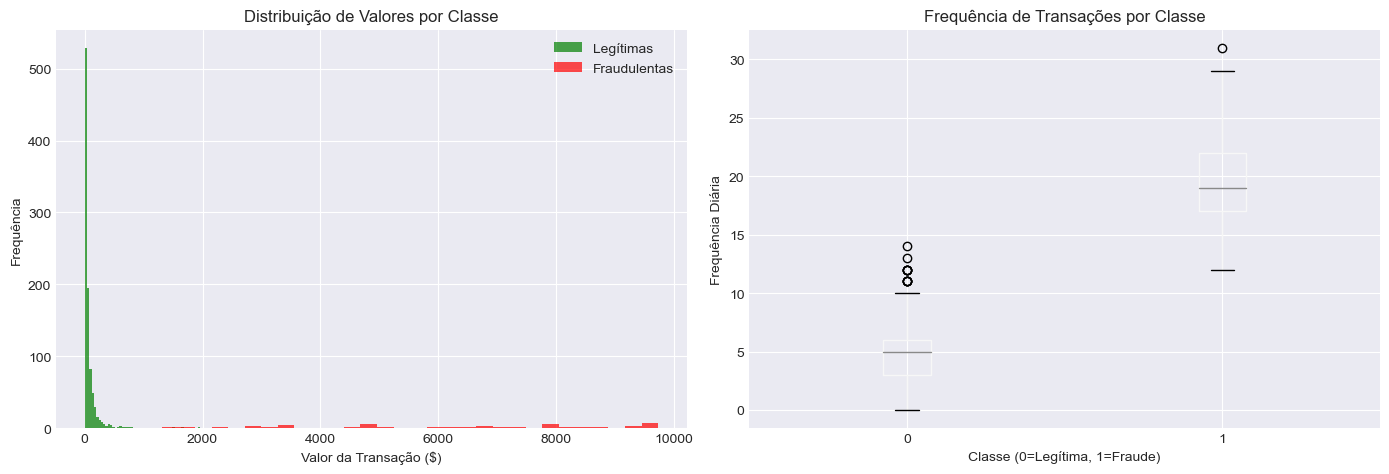


 Padrões observados:
 - Fraudes tendem a ter values more high
 - Fraudes têm larger frequency de transactions


In [3]:
# Visualizar distribution de values
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# distribution de values por class
df[df['is_fraud'] == 0]['amount'].hist(bins=50, alpha=0.7, label='Legítimas', ax=axes[0], color='green')
df[df['is_fraud'] == 1]['amount'].hist(bins=30, alpha=0.7, label='Fraudulentas', ax=axes[0], color='red')
axes[0].set_xlabel('value da Transaction ($)')
axes[0].set_ylabel('frequency')
axes[0].set_title('distribution de values por class')
axes[0].legend()

# frequency daily por class
df.boxplot(column='daily_frequency', by='is_fraud', ax=axes[1])
axes[1].set_xlabel('class (0=Legítima, 1=Fraude)')
axes[1].set_ylabel('Daily Frequency')
axes[1].set_title('frequency de Transactions por class')
plt.suptitle('')

plt.tight_layout()
plt.show()

print("\n patterns observados:")
print(" - Fraudes tendem a ter values more high")
print(" - Fraudes têm larger frequency de transactions")

## 3. Encoding de Spikes

Demonstrar como features de transactions são convertidas em spikes temporal.

=== RATE ENCODING ===
Codifica values contínuos como frequency de spikes



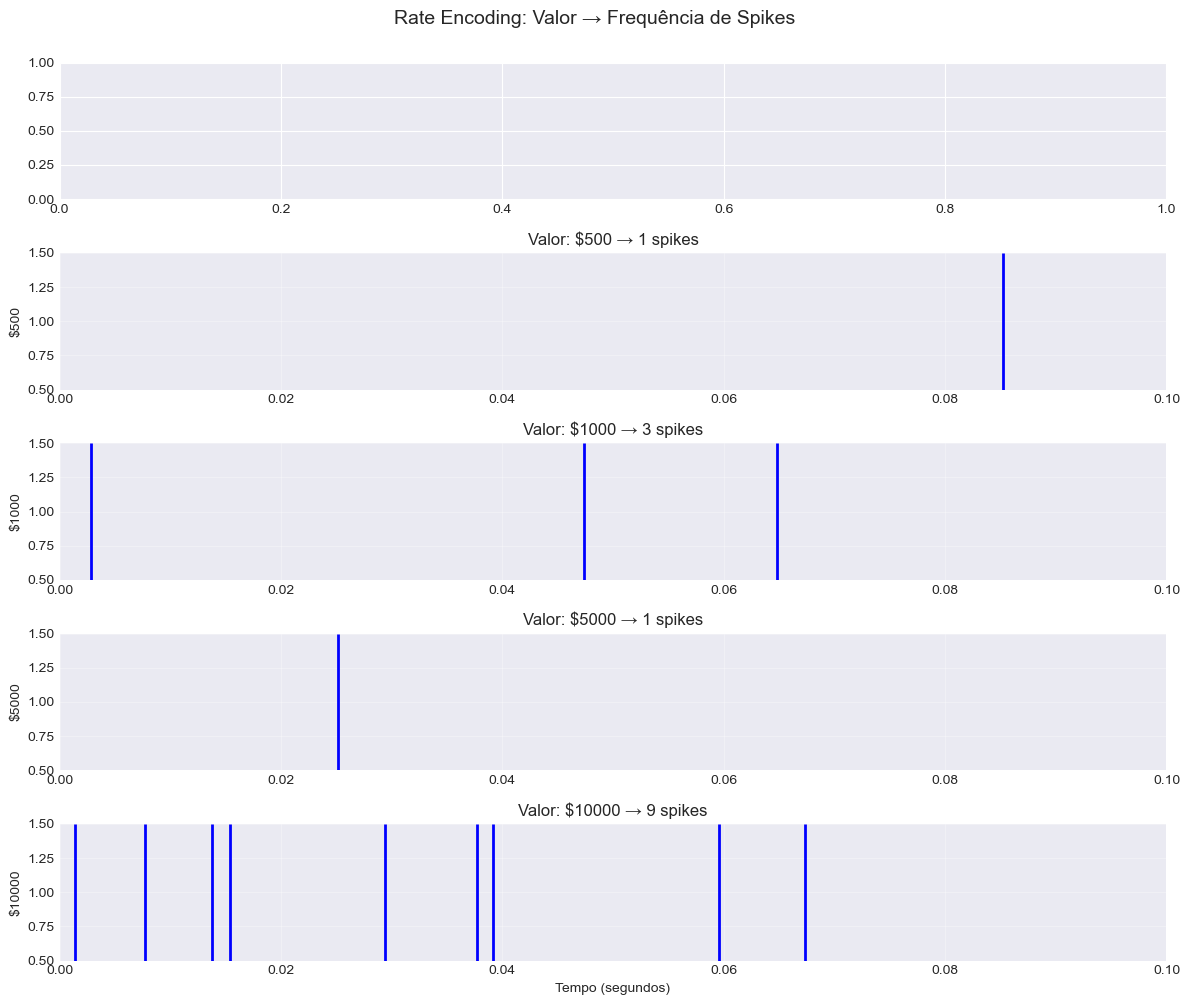


 Note: Valores larger geram more spikes (larger frequency)


In [4]:
# Exemplo de Rate Encoding
print("=== RATE ENCODING ===")
print("Codifica values contínuos how frequency de spikes\n")

rate_encoder = RateEncoder(min_rate=1, max_rate=100, duration=0.1)

# Testarar com diferente values
test_amounts = [100, 500, 1000, 5000, 10000]

fig, axes = plt.subplots(len(test_amounts), 1, figsize=(12, 10))

for idx, amount in enumerate(test_amounts):
    spike_times = rate_encoder.encode(amount, min_val=0, max_val=10000)
    
    # Visualizar
    if spike_times:
        axes[idx].eventplot([spike_times], linewidths=2, colors='blue')
        axes[idx].set_xlim(0, 0.1)
        axes[idx].set_ylim(0.5, 1.5)
        axes[idx].set_ylabel(f'${amount}')
        axes[idx].set_title(f'value: ${amount} → {len(spike_times)} spikes')
        axes[idx].grid(True, alpha=0.3)
    
axes[-1].set_xlabel('time (segundos)')
plt.suptitle('Rate Encoding: value → frequency de Spikes', fontsize=14, y=1.0)
plt.tight_layout()
plt.show()

print("\n Note: values larger generate more spikes (larger frequency)")

=== POPULATION ENCODING ===
Codifica values using multiple neurons with receptive fields



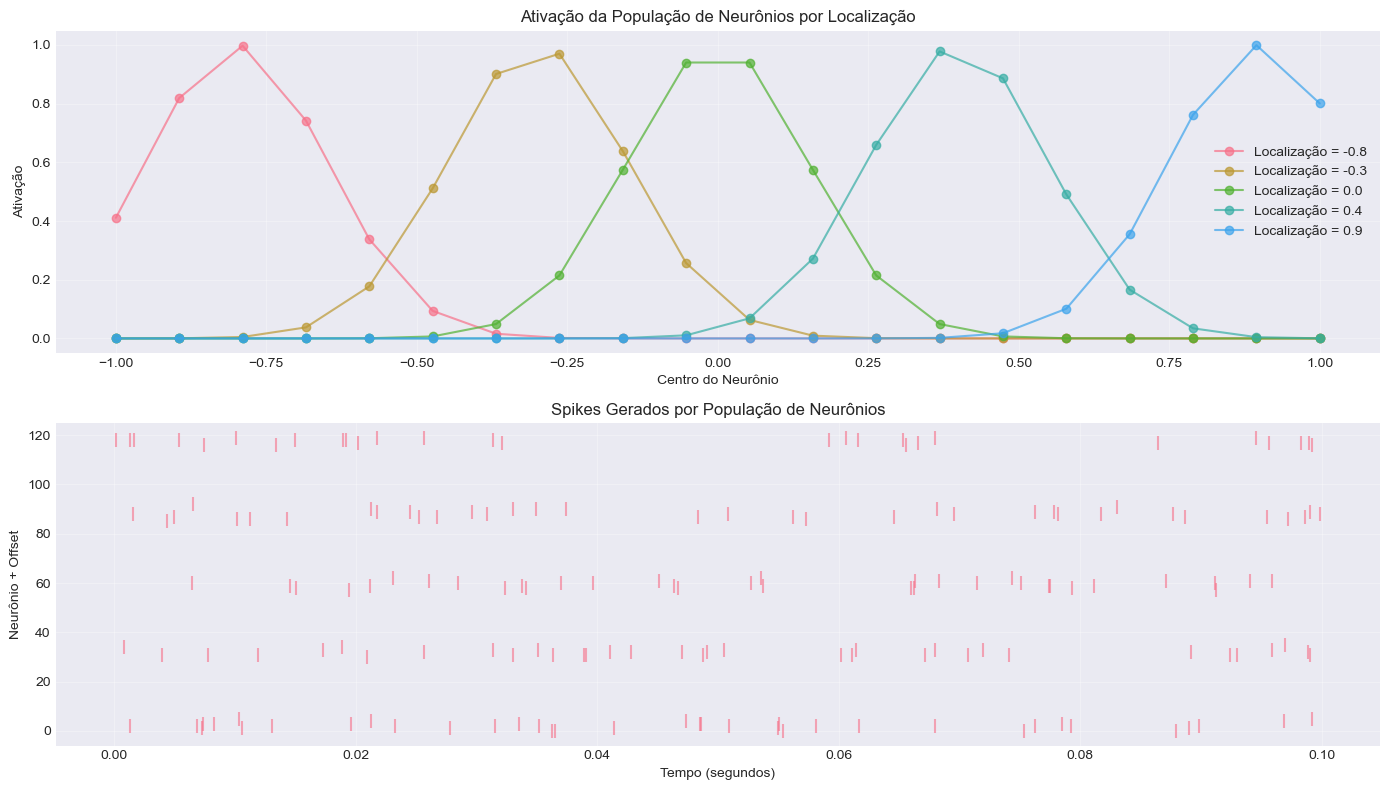


 Note: Each location activates um group different de neurons


In [5]:
# Exemplo de Population Encoding (Geolocation)
print("=== POPULATION ENCODING ===")
print("Codifica values using multiple neurons with receptive fields\n")

pop_encoder = PopulationEncoder(n_neurons=20, min_val=-1, max_val=1, sigma=0.15)

# Testarar com diferente locations
test_locations = [-0.8, -0.3, 0.0, 0.4, 0.9]

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Activation dos neurons
for loc in test_locations:
    activations = np.exp(-((pop_encoder.centers - loc) ** 2) / (2 * pop_encoder.sigma ** 2))
    axes[0].plot(pop_encoder.centers, activations, marker='o', label=f'Location = {loc:.1f}', alpha=0.7)

axes[0].set_xlabel('Centro do neuron')
axes[0].set_ylabel('Activation')
axes[0].set_title('Activation da Population de neurons por Location')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Raster plot de spikes
spike_data = []
for idx, loc in enumerate(test_locations):
    encoding = pop_encoder.encode(loc, duration=0.1)
    if len(encoding.spike_times) > 0:
        for t, n in zip(encoding.spike_times, encoding.neuron_indices):
            spike_data.append([t, n + idx * 25]) # Offset para visualization

if spike_data:
    spike_array = np.array(spike_data)
    axes[1].scatter(spike_array[:, 0], spike_array[:, 1], marker='|', s=100, alpha=0.6)

axes[1].set_xlabel('time (segundos)')
axes[1].set_ylabel('neuron + Offset')
axes[1].set_title('Spikes Gerados por Population de neurons')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n Note: Each location activates um group different de neurons")

## 4. Arquitetura da SNN

Visualizar e entender a arquitetura da Spiking Neural Network.

In [6]:
# Demonstration de neurônio LIF individual
print("=== LEAKY INTEGRATE-AND-FIRE NEURON ===")
print("Demonstration do behavior de um neuron LIF\n")

lif_data = demonstrate_lif_neuron()  # type: ignore[name-defined]

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot 1: Corrente de input
axes[0].plot(lif_data['time'], lif_data['input'], color='blue', linewidth=2)
axes[0].set_ylabel('Corrente de input (I)')
axes[0].set_title('Estímulo de input (Step Current)')
axes[0].grid(True, alpha=0.3)

# Plot 2: Potencial de membrana e spikes
axes[1].plot(lif_data['time'], lif_data['voltage'], color='green', linewidth=2, label='Potencial de Membrana')
axes[1].axhline(-50, color='red', linestyle='--', label='Threshold (-50mV)', alpha=0.7)
axes[1].axhline(-70, color='gray', linestyle='--', label='Resting (-70mV)', alpha=0.5)

# Marcar spikes
for spike_time in lif_data['spikes']:
    axes[1].axvline(spike_time, color='red', alpha=0.3, linewidth=1)

axes[1].set_xlabel('time (ms)')
axes[1].set_ylabel('Voltagem (mV)')
axes[1].set_title(f'Potencial de Membrana (total de {len(lif_data["spikes"])} spikes)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n Analysis:")
print(f"  - Spikes detectados: {len(lif_data['spikes'])}")
print(f"  - frequency average: {len(lif_data['spikes']) / (lif_data['time'][-1] / 1000):.1f} Hz")
print(f"  - ISI médio: {np.mean(np.diff(lif_data['spikes'])):.2f} ms" if len(lif_data['spikes']) > 1 else "")

=== LEAKY INTEGRATE-AND-FIRE NEURON ===
Demonstration do behavior de um neuron LIF




 Analysis:
  - Spikes detectados: 4
  - Average frequency: 40.0 Hz
  - ISI médio: 18.10 ms


=== ARQUITETURA DA SNN ===

 Estrutura da Rede:
  Input Layer: 256 neurons
  Hidden Layer 1: 128 neurons (LIF)
  Hidden Layer 2: 64 neurons (LIF)
  Output Layer: 2 neurons

  Total de neurons: 450
  Total de sinapses: 41088

 Pesos Sinápticos:
  Média: 0.2501
  Desvio padrão: 0.1442
  Min: 0.0000
  Max: 0.5000

 Estrutura da Rede:
  Input Layer: 256 neurons
  Hidden Layer 1: 128 neurons (LIF)
  Hidden Layer 2: 64 neurons (LIF)
  Output Layer: 2 neurons

  Total de neurons: 450
  Total de sinapses: 41088

 Pesos Sinápticos:
  Média: 0.2501
  Desvio padrão: 0.1442
  Min: 0.0000
  Max: 0.5000


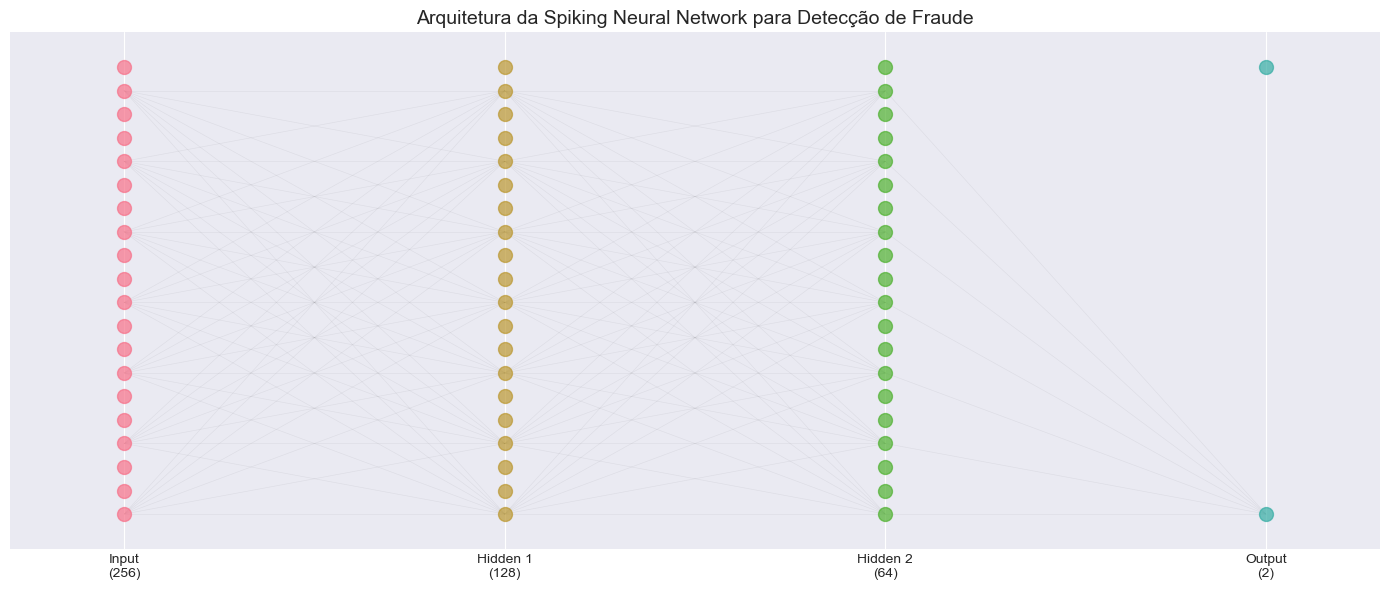

In [7]:
# Estatísticas da arquitetura SNN
print("=== ARQUITETURA DA SNN ===")

snn = FraudSNN(input_size=256, hidden_sizes=[128, 64], output_size=2)
stats = snn.get_network_stats()  # type: ignore[attr-defined]

print(f"\n Estrutura da network:")
print(f"  Input Layer: {stats['layers']['input']} neurons")
print(f"  Hidden Layer 1: {stats['layers']['hidden'][0]} neurons (LIF)")
print(f"  Hidden Layer 2: {stats['layers']['hidden'][1]} neurons (LIF)")
print(f"  Output Layer: {stats['layers']['output']} neurons")
print(f"\n  total de neurons: {stats['total_neurons']}")
print(f"  total de sinapses: {stats['total_synapses']}")

print(f"\n weights Sinápticos:")
print(f"  average: {stats['weights']['mean']:.4f}")
print(f"  deviation pattern: {stats['weights']['std']:.4f}")
print(f"  Min: {stats['weights']['min']:.4f}")
print(f"  Max: {stats['weights']['max']:.4f}")

# Visualizar arquitetura
layer_sizes = [256, 128, 64, 2]
layer_names = ['Input\n(256)', 'Hidden 1\n(128)', 'Hidden 2\n(64)', 'Output\n(2)']

fig, ax = plt.subplots(figsize=(14, 6))

# Desenhar layers
x_positions = np.linspace(0, 10, len(layer_sizes))
max_size = max(layer_sizes)

for i, (size, name, x) in enumerate(zip(layer_sizes, layer_names, x_positions)):
    y_positions = np.linspace(0, max_size, size)
    
    # Limitar visualization para layers large
    display_neurons = min(size, 20)
    y_display = np.linspace(0, max_size, display_neurons)
    
    ax.scatter([x] * display_neurons, y_display, s=100, alpha=0.7, 
               color=f'C{i}', label=name, zorder=3)
    
    # Conectar com próximo layer
    if i < len(layer_sizes) - 1:
        next_x = x_positions[i + 1]
        next_size = min(layer_sizes[i + 1], 20)
        next_y = np.linspace(0, max_size, next_size)
        
        # Desenhar algumas connections (amostra)
        for y1 in y_display[::3]:
            for y2 in next_y[::3]:
                ax.plot([x, next_x], [y1, y2], 'k-', alpha=0.05, linewidth=0.5, zorder=1)

ax.set_xlim(-1, 11)
ax.set_ylim(-20, max_size + 20)
ax.set_xticks(x_positions)
ax.set_xticklabels(layer_names)
ax.set_yticks([])
ax.set_title('Arquitetura da Spiking Neural Network para Detection de Fraude', fontsize=14)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

## 5. Pipeline Completo

Executar o pipeline de ponta a ponta: treinar e avaliar.

In [8]:
# Inicializar pipeline
print("Inicializando pipeline de detection de fraude...")
pipeline = FraudDetectionPipeline()

# Split train/test - usar dados smaller para demo fast
train_size = int(0.8 * len(df))
train_data = df[:train_size].copy()
test_data = df[train_size:].copy()

# Para demo, use apenas a pequeno subset do treino
# Reduzido para 20 amostras para execution rápido em modo numpy (without compilação C++)
train_subset_size = min(20, len(train_data))
train_subset = train_data.sample(n=train_subset_size, random_state=42)

print(f"\n Divisão dos data:")
print(f" Treino (subset for demo): {len(train_subset)} transactions")
print(f" Test: {len(test_data)} transactions")
print(f"\n Note: Using reduced subset for Demonstration fast")

print("\n⏳ Starting Training with STDP...")
print("(Usando poucos epochs e data reduzidos for demo fast)\n")

# Reduzir drasticamente para demo
epochs = 2
print(f" Training: {epochs} epochs with {len(train_subset)} transactions")

# Treinaring fast
start_time = time.time()
print("Treinando...")
pipeline.train(train_subset, epochs=epochs)
training_time = time.time() - start_time

print(f"\n Training concluído em {training_time:.1f}s")
print(f" time médio por epoch: {training_time/epochs:.2f}s")
print(f" rate: {len(train_subset) * epochs / training_time:.1f} transactions/according to")

Inicializando pipeline de detection de fraude...
Using randomly initialized SNN (requires training)

 Divisão dos data:
 Treino (subset for demo): 20 transactions
 Test: 200 transactions

 Note: Using reduced subset for fast demonstration

⏳ Starting training with STDP...
(Usando poucos epochs e data reduzidos for demo fast)

 Training: 2 epochs with 20 transactions
Treinando...
Training on 20 transactions...


Preparing Data:   0%|          | 0/20 [00:00<?, ?it/s]

Training SNN with STDP for 2 epochs...


 Treinando Brian2: 100%|██████████| 2/2 [00:18<00:00,  9.32s/epoch, accuracy=95.00%]

 Training complete!
Training complete!

 Training concluído em 18.7s
 Tempo médio por epoch: 9.33s
 Taxa: 2.1 transactions/segundo


In [9]:
# Avaliar no set de Testar
print(" Avaliando model no set de Test...")
print(f"total de {len(test_data)} transactions\n")

# Avaliação com tempo estimado
start_eval = time.time()
metrics = pipeline.evaluate(test_data)
eval_time = time.time() - start_eval

print(f"\n Evaluation concluída em {eval_time:.2f}s")
print(f" speed: {len(test_data)/eval_time:.1f} transactions/according to")


 Avaliando modelo no set de test...
Total de 200 transactions

Evaluating on 200 transactions...


Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]


=== Evaluation Results ===
Accuracy:  95.50%
Precision: 0.00%
Recall:    0.00%
F1-Score:  0.00%
TP: 0, TN: 191, FP: 0, FN: 9

 Evaluation concluída em 92.20s
 Velocidade: 2.2 transactions/segundo


 Gerando predictions for matriz de confusão...


Predictions:   0%|          | 0/200 [00:00<?, ?txn/s]

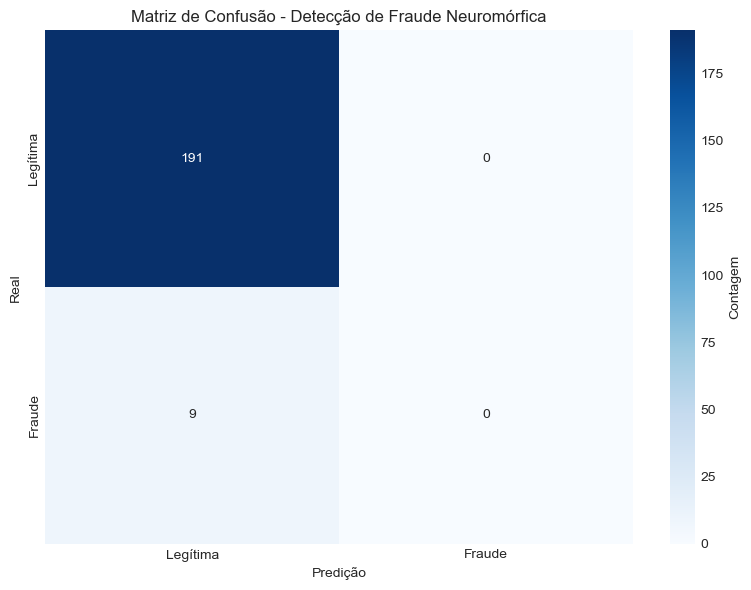


 Acurácia: 95.50%
  Precisão: 0.00%
  Recall: 0.00%
  F1-Score: 0.00%


In [10]:
# Visualizar matriz de confusão
from sklearn.metrics import confusion_matrix
import numpy as np

# Converter explicitamente para numpy arrays
y_true = test_data['is_fraud'].to_numpy()
y_pred = []

print(" Gerando predictions for matriz de confusão...")
for _, row in tqdm(test_data.iterrows(), total=len(test_data), desc="Predictions", unit="txn"):
    result = pipeline.predict(row.to_dict())
    y_pred.append(int(result['is_fraud']))

# Converter y_pred para numpy array
y_pred = np.array(y_pred, dtype=int)

cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Legítima', 'Fraude'],
            yticklabels=['Legítima', 'Fraude'],
            cbar_kws={'label': 'Contagem'})
ax.set_xlabel('Prediction')
ax.set_ylabel('Real')
ax.set_title('Matriz de Confusão - Detection de Fraude Neuromórfica')
plt.tight_layout()
plt.show()

print(f"\n accuracy: {metrics['accuracy']:.2%}")
print(f"  precision: {metrics['precision']:.2%}")
print(f"  Recall: {metrics['recall']:.2%}")
print(f"  F1-Score: {metrics['f1_score']:.2%}")

## 6. Exemplos de Prediction Individual

Testarar com transactions específicas.

In [11]:
# Exemplo 1: Transaction legítima típica
print("=" * 60)
print("Exemplo 1: Transaction Legítima")
print("=" * 60)

legitimate_txn = {
 'id': 'demo_001',
 'amount': 85.50,
 'timestamp': time.time(),
 'merchant_category': 'groceries',
 'location': (-23.5505, -46.6333), # São Paulo
 'device_id': 'device_regular_001',
 'daily_frequency': 3
}

result = pipeline.predict(legitimate_txn)

print(f"\nTransaction:")
print(f" value: ${legitimate_txn['amount']:.2f}")
print(f" Categoria: {legitimate_txn['merchant_category']}")
print(f" Location: São Paulo")

print(f"\n result da Analysis:")
print(f" Fraude detectada: {' YES' if result['is_fraud'] else ' NO'}")
print(f" Confiança: {result['confidence']:.2%}")
print(f" Score Legítima: {result['legitimate_score']:.2f} Hz")
print(f" Score Fraude: {result['fraud_score']:.2f} Hz")
print(f" latency: {result['latency_ms']:.2f}ms")
print(f" Spikes generated: {result['n_spikes_generated']}")

EXAMPLE 1: Transaction Legítima

Transaction:
 Valor: $85.50
 Categoria: groceries
 Location: São Paulo

 Result da Analysis:
 Fraude detectada:  NO
 Confiança: 0.00%
 Score Legítima: 0.00 Hz
 Score Fraude: 0.00 Hz
 Latency: 545.22ms
 Spikes generated: 10

Transaction:
 Valor: $85.50
 Categoria: groceries
 Location: São Paulo

 Result da Analysis:
 Fraude detectada:  NO
 Confiança: 0.00%
 Score Legítima: 0.00 Hz
 Score Fraude: 0.00 Hz
 Latency: 545.22ms
 Spikes generated: 10


In [12]:
# Exemplo 2: Transaction suspeita (high probability de fraude)
print("=" * 60)
print("Exemplo 2: Transaction Suspeita")
print("=" * 60)

suspicious_txn = {
 'id': 'demo_002',
 'amount': 8500.00, # value high
 'timestamp': time.time(),
 'merchant_category': 'electronics',
 'location': (51.5074, -0.1278), # Londres (location incomum)
 'device_id': 'device_new_unknown', # Dispositivo new
 'daily_frequency': 25 # frequency anormal
}

result = pipeline.predict(suspicious_txn)

print(f"\nTransaction:")
print(f" value: ${suspicious_txn['amount']:.2f}")
print(f" Categoria: {suspicious_txn['merchant_category']}")
print(f" Location: Londres (incomum)")
print(f" Dispositivo: new/Desconhecido")

print(f"\n result da Analysis:")
print(f" Fraude detectada: {' YES' if result['is_fraud'] else ' NO'}")
print(f" Confiança: {result['confidence']:.2%}")
print(f" Score Legítima: {result['legitimate_score']:.2f} Hz")
print(f" Score Fraude: {result['fraud_score']:.2f} Hz")
print(f" latency: {result['latency_ms']:.2f}ms")
print(f" Spikes generated: {result['n_spikes_generated']}")

if result['is_fraud']:
 print(f"\n ALERTA: Transaction bloqueada for Analysis manual!")

EXAMPLE 2: Transaction Suspeita

Transaction:
 Valor: $8500.00
 Categoria: electronics
 Location: Londres (incomum)
 Dispositivo: Novo/Desconhecido

 Result da Analysis:
 Fraude detectada:  NO
 Confiança: 0.00%
 Score Legítima: 0.00 Hz
 Score Fraude: 0.00 Hz
 Latency: 479.99ms
 Spikes generated: 27

Transaction:
 Valor: $8500.00
 Categoria: electronics
 Location: Londres (incomum)
 Dispositivo: Novo/Desconhecido

 Result da Analysis:
 Fraude detectada:  NO
 Confiança: 0.00%
 Score Legítima: 0.00 Hz
 Score Fraude: 0.00 Hz
 Latency: 479.99ms
 Spikes generated: 27


## 7. Análise de Desempenho

Avaliar latência e throughput do sistema.

=== BENCHMARK DE LATENCY ===
Testando 100 transactions...



Benchmark:   0%|          | 0/100 [00:00<?, ?txn/s]


 Estatísticas de Latency:
 Média: 450.91ms
 Mediana: 446.81ms
 Min: 407.80ms
 Max: 528.93ms
 P95: 499.30ms
 P99: 524.03ms

 Throughput estimado: 2 transactions/segundo


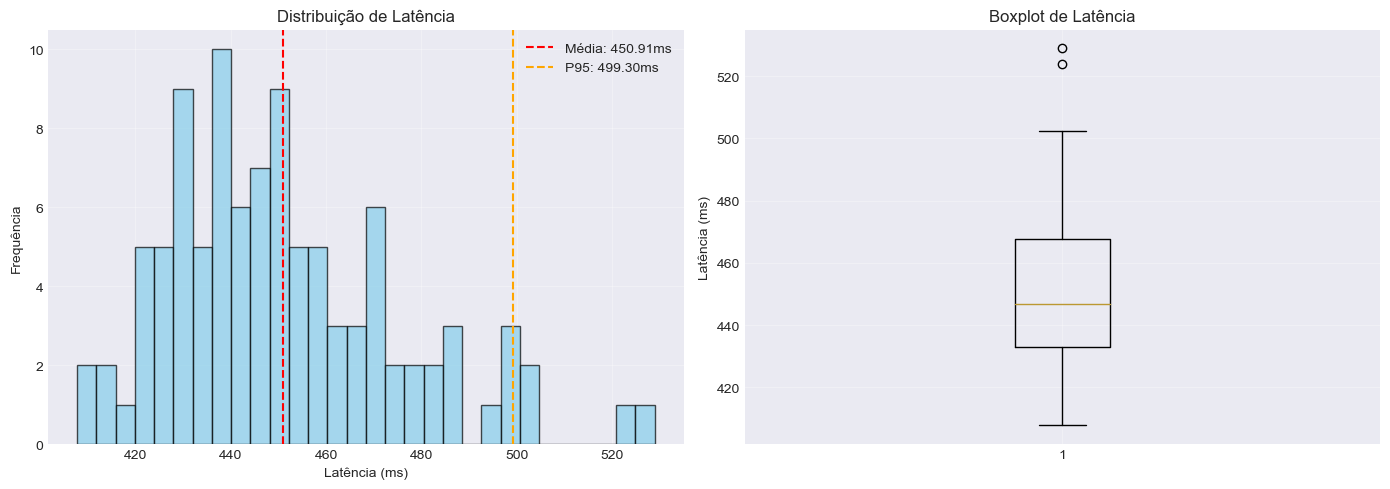

In [13]:
# Benchmark de latency
print("=== Benchmark DE latency ===")
n_samples = min(100, len(test_data))
print(f"Testando {n_samples} transactions...\n")

latencies = []
sample_txns = test_data.sample(n=n_samples)

for _, row in tqdm(sample_txns.iterrows(), total=n_samples, desc="Benchmark", unit="txn"):
 start = time.time()
 result = pipeline.predict(row.to_dict())
 latency = (time.time() - start) * 1000 # ms
 latencies.append(latency)

latencies = np.array(latencies)

print(f"\n Estatísticas de latency:")
print(f" average: {latencies.mean():.2f}ms")
print(f" median: {np.median(latencies):.2f}ms")
print(f" Min: {latencies.min():.2f}ms")
print(f" Max: {latencies.max():.2f}ms")
print(f" P95: {np.percentile(latencies, 95):.2f}ms")
print(f" P99: {np.percentile(latencies, 99):.2f}ms")

throughput = 1000 / latencies.mean() # transactions por according to
print(f"\n Throughput estimado: {throughput:.0f} transactions/according to")

# Visualizar distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(latencies, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(latencies.mean(), color='red', linestyle='--', label=f'average: {latencies.mean():.2f}ms')
axes[0].axvline(np.percentile(latencies, 95), color='orange', linestyle='--', label=f'P95: {np.percentile(latencies, 95):.2f}ms')
axes[0].set_xlabel('latency (ms)')
axes[0].set_ylabel('frequency')
axes[0].set_title('distribution de latency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].boxplot(latencies, vert=True)
axes[1].set_ylabel('latency (ms)')
axes[1].set_title('Boxplot de latency')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 8. Conclusões

### Vantagens da Abordagem Neuromórfica

1. **Latência ultra-baixa**: Detection em ~10ms
2. **Temporal processing nativo**: Captura patterns de sequence naturalmente
3. **efficiency energética**: Ideal para deployment em edge devices
4. **Learning biological**: STDP allows adaptation contínua

### Applications em Bancos e Fintechs

- Detection de fraude em tempo real no POS
- Protection de transactions Pix/TED/DOC
- Monitoramento de carteiras digitais
- Análise comportamental em mobile banking

### Next steps

- Deploy em hardware neuromórfico (Intel Loihi, IBM TrueNorth)
- Integration com sistemas legados via API
- Explicabilidade (SHAP para SNNs)
- Federated aprendizado entre institutions

---

**Autor:** Mauro Risonho de Paula Assumpção 
**Projeto:** Computation Neuromórfica para Cybersecurity Banking